In [26]:
import pandas as pd
import numpy as np
import itertools as itertool
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
# import pandas_datareader.data as web

In [2]:
# !pip install pandas-datareader

In [3]:
# !pip install pmdarima

In [4]:
df =pd.read_excel('expo_nme.xlsx', index_col = 0)
df

,Expo_NME
Mes,
2006-01-01,8.101333e+08
2006-02-01,9.691270e+08
2006-03-01,1.071192e+09
2006-04-01,9.296880e+08
2006-05-01,1.088814e+09
...,...
2023-05-01,1.898318e+09
2023-06-01,1.704195e+09
2023-07-01,1.638097e+09


In [5]:
sns.set()

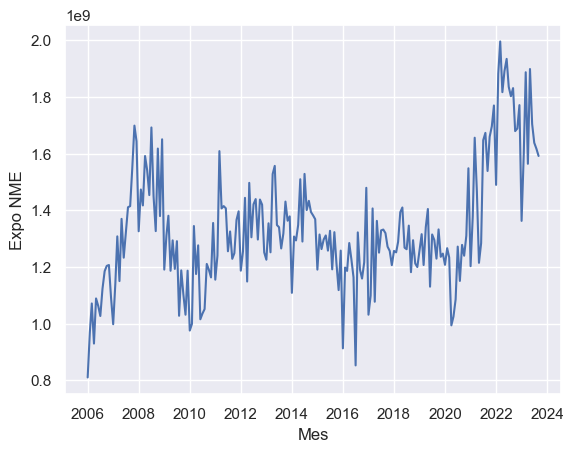

In [6]:
# Gráfica de todos los periodos
plt.ylabel('Expo NME')
plt.xlabel('Mes')
plt.plot(df.index, df['Expo_NME'], )

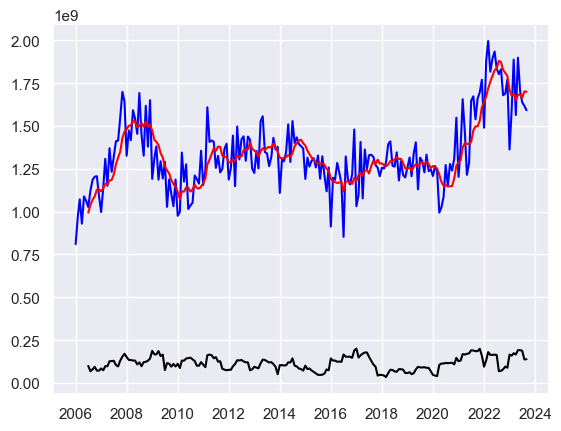

In [7]:
#Gráfica donde separa la tendencia de las desviaciones estándar de cada periodo para probar por estacionalidad
rolling_mean = df.rolling(7).mean()
rolling_std = df.rolling(7).std()
plt.plot(df, color="blue",label="Original")
plt.plot(rolling_mean, color="red", label="Rolling Mean")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation")

In [8]:
#Prueba formal de estacionalidad (Dicky-fuller)
#Se podría decir que la serie no tiene estacionalidad
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -3.239222              Test Statistics
1    0.017824                      p-value
2   15.000000             No. of lags used
3  197.000000  Number of observations used
4   -3.463987          critical value (1%)
5   -2.876326          critical value (5%)
6   -2.574652         critical value (10%)


Modelos

In [9]:
#Separamos las bases de entrenamiento y prueba por la fecha
Train = df[df.index < pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
Train
Test = df[df.index > pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
Test

,Expo_NME
Mes,
2023-01-01,1.362511e+09
2023-02-01,1.598769e+09
2023-03-01,1.886931e+09
2023-04-01,1.563917e+09
2023-05-01,1.898318e+09
2023-06-01,1.704195e+09
2023-07-01,1.638097e+09
2023-08-01,1.617054e+09
2023-09-01,1.591565e+09


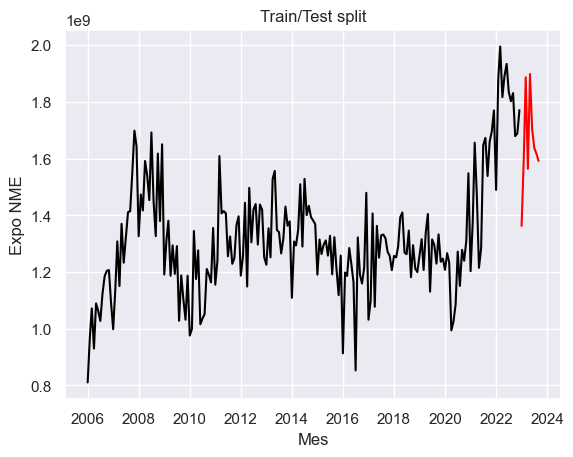

In [10]:
plt.plot(Train, color = "black")
plt.plot(Test, color = "red")
plt.ylabel('Expo NME')
plt.xlabel('Mes')
plt.title("Train/Test split")
plt.show()

In [11]:
##ARMA - media móvil
from statsmodels.tsa.statespace.sarimax import SARIMAX
y = Train['Expo_NME']
ARMA = SARIMAX(y, order = (1,0,6)) 
ARMA = ARMA.fit()
y_pred = ARMA.get_forecast(len(Test.index))
y_pred_ARMA = y_pred.conf_int(alpha = 0.05) 
y_pred_ARMA["Predictions"] = ARMA.predict(start = y_pred_ARMA.index[0], end = y_pred_ARMA.index[-1])
y_pred_ARMA.index = Test.index
y_pred_outARMA = y_pred_ARMA["Predictions"] 
arma_rmse = np.sqrt(mean_squared_error(Test["Expo_NME"].values, y_pred_ARMA["Predictions"]))
print("RMSE: ",arma_rmse)

# Es un modelo ARMA(1,6), donde la variable de exportaciones tiene un solo rezago en el tiempo y el error tiene 6 rezagos,
# lo que significa que los choques externos de las variables logran tener impacto hasta 6 meses después de que hayan ocurrido. 

C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RMSE:  169698393.4491945


In [12]:
y_pred_outARMA

Mes
2023-01-01    1.728873e+09
2023-02-01    1.730541e+09
2023-03-01    1.726361e+09
2023-04-01    1.710063e+09
2023-05-01    1.710789e+09
2023-06-01    1.709004e+09
2023-07-01    1.707312e+09
2023-08-01    1.705621e+09
2023-09-01    1.703932e+09
Name: Predictions, dtype: float64

In [13]:
Test

,Expo_NME
Mes,
2023-01-01,1.362511e+09
2023-02-01,1.598769e+09
2023-03-01,1.886931e+09
2023-04-01,1.563917e+09
2023-05-01,1.898318e+09
2023-06-01,1.704195e+09
2023-07-01,1.638097e+09
2023-08-01,1.617054e+09
2023-09-01,1.591565e+09


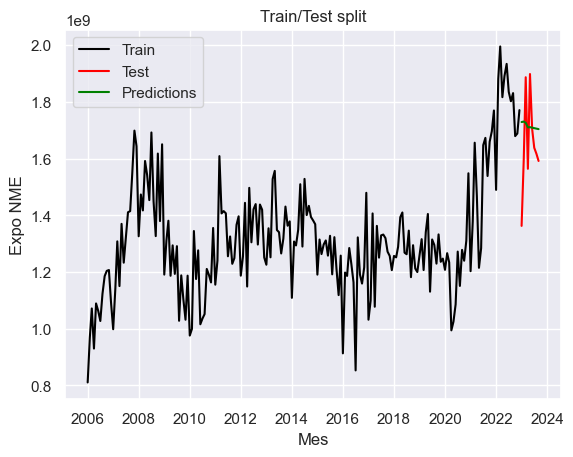

In [14]:
plt.plot(Train, color = "black", label = 'Train')
plt.plot(Test, color = "red", label = 'Test')
plt.plot(y_pred_outARMA, color='green', label = 'Predictions')
plt.legend()
plt.ylabel('Expo NME')
plt.xlabel('Mes')
plt.title("Train/Test split")
plt.show()

In [15]:
# ARIMA - Modelos Autorregresivos Integrados de Promedio Móvil
from statsmodels.tsa.arima.model import ARIMA
ARIMA = ARIMA(y, order = (1,0,2))
ARIMA = ARIMA.fit()
y_pred = ARIMA.get_forecast(len(Test.index))
y_pred_ARIMA = y_pred.conf_int(alpha = 0.05) 
y_pred_ARIMA["Predictions"] = ARIMA.predict(start = y_pred_ARIMA.index[0], end = y_pred_ARIMA.index[-1])
y_pred_ARIMA.index = Test.index
y_pred_outARIMA = y_pred_ARIMA["Predictions"] 
arima_rmse = np.sqrt(mean_squared_error(Test["Expo_NME"].values, y_pred_ARIMA["Predictions"]))
print("RMSE: ",arima_rmse)

#ARIMA(1,0,2) 

C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE:  162651101.38360703


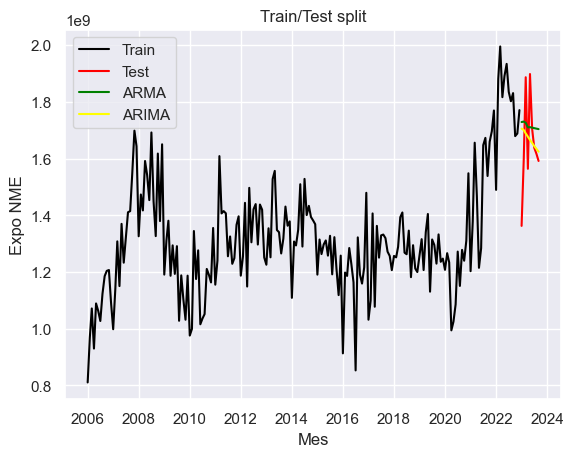

In [16]:
plt.plot(Train, color = "black", label = 'Train')
plt.plot(Test, color = "red", label = 'Test')
plt.plot(y_pred_outARMA, color='green', label = 'ARMA')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA')
plt.legend()
plt.ylabel('Expo NME')
plt.xlabel('Mes')
plt.title("Train/Test split")
plt.show()

In [17]:
y_pred_outARIMA

Mes
2023-01-01    1.705642e+09
2023-02-01    1.700665e+09
2023-03-01    1.688691e+09
2023-04-01    1.677094e+09
2023-05-01    1.665862e+09
2023-06-01    1.654983e+09
2023-07-01    1.644446e+09
2023-08-01    1.634240e+09
2023-09-01    1.624355e+09
Name: Predictions, dtype: float64

In [18]:
# SARIMA - se basa en la aplicación de los modelos ARMA a una serie temporal transformada 
# donde se ha eliminado el comportamiento estacional y no estacionario, para una serie estacional con s periodos 
# por año se utilizan los modelos SARIMA (p, d, q) x (P, D, Q) s. -- Es un ARIMA estacional

# p, d y q son los parámetros de orden AR, diferencias y MA no estacionales, mientras que 
# P, D y Q son las versiones estacionales de los mismos parámetros en su versión estacional. 
# S es el número de periodos que se demora en repetirse la estacionalidad ej: 12 meses

from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAX = SARIMAX(y, order = (1,0,3), seasonal_order=(1,1,2,24))
SARIMAX = SARIMAX.fit()
y_pred = SARIMAX.get_forecast(len(Test.index))
y_pred_SARIMA = y_pred.conf_int(alpha = 0.05) 
y_pred_SARIMA["Predictions"] = SARIMAX.predict(start = y_pred_SARIMA.index[0], end = y_pred_SARIMA.index[-1])
y_pred_SARIMA.index = Test.index
y_pred_outSARIMA = y_pred_SARIMA["Predictions"] 

C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


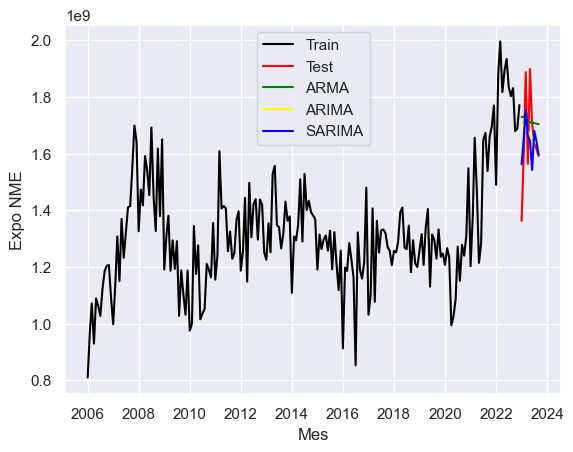

In [19]:
plt.plot(Train, color = "black", label = 'Train')
plt.plot(Test, color = "red", label = 'Test')
plt.plot(y_pred_outARMA, color='green', label = 'ARMA')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA')
plt.plot(y_pred_outSARIMA, color='Blue', label = 'SARIMA')
plt.legend()
plt.ylabel('Expo NME')
plt.xlabel('Mes')
plt.show()

In [20]:
y_pred_outSARIMA

Mes
2023-01-01    1.562465e+09
2023-02-01    1.653983e+09
2023-03-01    1.753132e+09
2023-04-01    1.660060e+09
2023-05-01    1.646386e+09
2023-06-01    1.542264e+09
2023-07-01    1.680310e+09
2023-08-01    1.644493e+09
2023-09-01    1.596257e+09
Name: Predictions, dtype: float64

In [21]:
Test

,Expo_NME
Mes,
2023-01-01,1.362511e+09
2023-02-01,1.598769e+09
2023-03-01,1.886931e+09
2023-04-01,1.563917e+09
2023-05-01,1.898318e+09
2023-06-01,1.704195e+09
2023-07-01,1.638097e+09
2023-08-01,1.617054e+09
2023-09-01,1.591565e+09


In [22]:
# Después de escoger el modelo, se hacen las predicciones finales acá

In [22]:
Predict = [['2023-10-01', ''], ['2023-11-01', ''], ['2023-12-01', ''], 
           ['2024-01-01', ''], ['2024-02-01', ''], ['2024-03-01', ''], 
           ['2024-04-01', ''], ['2024-05-01', ''], ['2024-06-01', ''], 
           ['2024-07-01', ''], ['2024-08-01', ''], ['2024-09-01', ''], 
           ['2024-10-01', ''], ['2024-11-01', ''], ['2024-12-01', '']]
Predict = pd.DataFrame(Predict, columns=['Mes', 'Expo_NME'])
Predict.set_index('Mes', inplace=True)
Predict

,Expo_NME
Mes,
2023-10-01,
2023-11-01,
2023-12-01,
2024-01-01,
2024-02-01,
2024-03-01,
2024-04-01,
2024-05-01,
2024-06-01,


In [23]:
y_pred = SARIMAX.get_forecast(len(Predict.index))
y_pred_SARIMA = y_pred.conf_int(alpha = 0.05) 
y_pred_SARIMA["Predictions"] = SARIMAX.predict(start = y_pred_SARIMA.index[0], end = y_pred_SARIMA.index[-1])
y_pred_SARIMA.index = Predict.index
y_pred_outSARIMA = y_pred_SARIMA["Predictions"] 
y_pred_outSARIMA

Mes
2023-10-01    1.562465e+09
2023-11-01    1.653983e+09
2023-12-01    1.753132e+09
2024-01-01    1.660060e+09
2024-02-01    1.646386e+09
2024-03-01    1.542264e+09
2024-04-01    1.680310e+09
2024-05-01    1.644493e+09
2024-06-01    1.596257e+09
2024-07-01    1.628957e+09
2024-08-01    1.598458e+09
2024-09-01    1.623142e+09
2024-10-01    1.460271e+09
2024-11-01    1.627971e+09
2024-12-01    1.669159e+09
Name: Predictions, dtype: float64